In [0]:
#Mount Drive

from google.colab import drive
drive.mount("/content/drive") 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#Extract Zip Files

from zipfile import ZipFile
file_name = "/content/drive/My Drive/Ham10000/HamPart1.zip"

with ZipFile(file_name,'r') as zip:
  zip.extractall("/Ham10000")
  print('Done')

Done


In [0]:
import os
import gc
from PIL import Image
import tensorflow

import tqdm
import numpy as np
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, LeakyReLU
from keras.applications import VGG16
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import check_random_state


sns.set()
np.random.seed(0);
tensorflow.random.set_seed(0)
check_random_state(0);

In [0]:
train_imgs, test_imgs = [], []
train_labels, test_labels = [], []

for img_path in os.listdir('/Ham10000/Ham10000/train/benign'):
    train_imgs.append('/Ham10000/Ham10000/train/benign/' + img_path)
    train_labels.append(0)
    
for img_path in os.listdir('/Ham10000/Ham10000/train/malignant'):
    train_imgs.append('/Ham10000/Ham10000/train/malignant/' + img_path)
    train_labels.append(1)
    
for img_path in os.listdir('/Ham10000/Ham10000/test/benign'):
    test_imgs.append('/Ham10000/Ham10000/test/benign/' + img_path)
    test_labels.append(0)
    
for img_path in os.listdir('/Ham10000/Ham10000/test/malignant'):
    test_imgs.append('/Ham10000/Ham10000/test/malignant/' + img_path)
    test_labels.append(1)
    
train_imgs, test_imgs = np.array(train_imgs), np.array(test_imgs)
train_labels, test_labels = np.array(train_labels), np.array(test_labels)
    
class_distribution = np.bincount(np.concatenate([train_labels, test_labels]))
    
print('Size of train set:', len(train_imgs))
print('Size of test set:', len(test_imgs))
print(class_distribution[0], 'benign labeled samples and', class_distribution[1], 'malignant')

Size of train set: 2637
Size of test set: 660
1800 benign labeled samples and 1497 malignant


In [0]:
# Load the images to memory
xtrain, xtest = [], []
ytrain, ytest = train_labels, test_labels

for filename in train_imgs:
    xtrain.append(np.array(Image.open(filename)))
    
for filename in test_imgs:
    xtest.append(np.array(Image.open(filename)))
    
del train_imgs, test_imgs, train_labels, test_labels
xtrain, xtest = np.array(xtrain), np.array(xtest)

# Merge and split train and test set to have more train data
data = np.concatenate([xtrain, xtest])
labels = np.concatenate([ytrain, ytest])

# Spliting data to train, validation and test values
xtrain, xtest, ytrain, ytest = train_test_split(data, labels, test_size=.2, random_state=0)
xtra, xval, ytra, yval = train_test_split(xtrain, ytrain, test_size=.05, random_state=0, shuffle=False)

gc.collect()
print('Shape of the new train set:', xtra.shape)
print('Shape of the new test set:', xtest.shape)
print('Shape of the validation set:', xval.shape)

Shape of the new train set: (2505, 224, 224, 3)
Shape of the new test set: (660, 224, 224, 3)
Shape of the validation set: (132, 224, 224, 3)


In [0]:
data_generator = ImageDataGenerator(rotation_range=90,
                                    width_shift_range=0.15,
                                    height_shift_range=0.15,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    brightness_range=[0.8, 1.1],
                                    fill_mode='nearest')

new_samples, new_labels = next(data_generator.flow(xtra, ytra, batch_size=len(xtra)))
xtra = np.concatenate([xtra, new_samples])
ytra = np.concatenate([ytra, new_labels])

del new_samples, new_labels
print('New number of training samples:', len(xtra))

New number of training samples: 5010


In [0]:
# Normalizing data to 0,1 range.
xtra = xtra.astype('float32') / 255.
xtest = xtest.astype('float32') / 255.
xval = xval.astype('float32') / 255.

print('Training data shape:', xtra.shape)
print('Min value:', xtra.min())
print('Max value:', xtra.max())

Training data shape: (5010, 224, 224, 3)
Min value: 0.0
Max value: 1.0


In [0]:
# Build the model
model = Sequential()

model.add(VGG16(include_top=False, input_shape=(224, 224, 3,)))
model.add(Flatten())
model.add(Dense(32))
model.add(LeakyReLU(0.001))
model.add(Dense(16))
model.add(LeakyReLU(0.001))
model.add(Dense(1, activation='sigmoid'))
model.layers[0].trainable = False

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model.summary()

58892288/58889256 [==============================] - 2s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                802848    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16)                0         
_______________________________________________________

In [0]:
# Train the model
N_EPOCHS = 50
h = model.fit(xtra, ytra, validation_data=(xval, yval), epochs=N_EPOCHS, batch_size=20)

Train on 5010 samples, validate on 132 samples
Epoch 1/50
5010/5010 [==============================] - 46s 9ms/step - loss: 0.4409 - acc: 0.7926 - val_loss: 0.3469 - val_acc: 0.8485
Epoch 2/50
5010/5010 [==============================] - 37s 7ms/step - loss: 0.3444 - acc: 0.8453 - val_loss: 0.4044 - val_acc: 0.8106
Epoch 3/50
5010/5010 [==============================] - 38s 8ms/step - loss: 0.3023 - acc: 0.8671 - val_loss: 0.3190 - val_acc: 0.8485
Epoch 4/50
5010/5010 [==============================] - 38s 8ms/step - loss: 0.2663 - acc: 0.8760 - val_loss: 0.3020 - val_acc: 0.8636
Epoch 5/50
5010/5010 [==============================] - 39s 8ms/step - loss: 0.2380 - acc: 0.8922 - val_loss: 0.2909 - val_acc: 0.8561
Epoch 6/50
5010/5010 [==============================] - 39s 8ms/step - loss: 0.2239 - acc: 0.9020 - val_loss: 0.3927 - val_acc: 0.8106
Epoch 7/50
5010/5010 [==============================] - 39s 8ms/step - loss: 0.1942 - acc: 0.9172 - val_loss: 0.3884 - val_acc: 0.8636
Epoch 8/

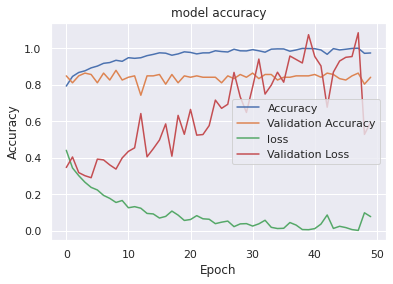

In [0]:
import matplotlib.pyplot as plt

plt.plot(h.history["acc"])
plt.plot(h.history['val_acc'])
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

In [0]:
print('Accuracy on test set:', model.evaluate(xtest, ytest)[1])
model.save('appDermis_vgg16.h5')

660/660 [==============================] - 6s 9ms/step
Accuracy on test set: 0.8530303239822388
